In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm

     -------------------------------------- 13.9/13.9 MB 592.7 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import sys
import os

sys.path.append("../")
DATASET_PATH = "../english_cleaned_lyrics.csv"

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from preprocessing.build_dataset import get_dataset_splits
from preprocessing.build_dataset import LABELS
from preprocessing.build_dataset import get_label_encoder
from preprocessing.SongsDataset import SongsDataset
from preprocessing.TokenizeTransformer import TokenizeTransformer
from preprocessing.RemoveStopwordsTransform import RemoveStopwordsTransform
from preprocessing.RemovePunctuationTransformer import RemovePunctuationTransformer
from torchvision import transforms
from nltk.tokenize import word_tokenize
import itertools
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Alex
[nltk_data]     D\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
X_train, y_train, X_test, y_test = get_dataset_splits(DATASET_PATH, train_size_p=0.8)

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
pipeline = ['tagger', 'lemmatizer', 'attribute_ruler']

nlp = spacy.load('en_core_web_sm')
disabled_pipelines = [proc for proc in nlp.pipe_names if proc not in pipeline]
print(disabled_pipelines)

['tok2vec', 'parser', 'ner']


In [8]:
! pip install num2words

In [6]:
from num2words import num2words
import re
import spacy
from copy import copy
from nltk.stem.snowball import SnowballStemmer
stop_words_spacy = nlp.Defaults.stop_words
stemmer = SnowballStemmer(language='english')

def get_processed_input(inputToProcess, removeStopwords = True):
    processed_item = copy(inputToProcess)
    # convert numbers to string
    processed_item = re.sub(r"(\d+)", lambda t: num2words(int(t.group(0)), lang='en'), processed_item)
    # remove punctuation
    processed_item = re.sub(r"\s+", ' ', re.sub(r"[^\w\s]", " ", processed_item))
    # remove stopwords
    if removeStopwords:
        processed_item = (" ").join([word for word in processed_item.split(' ') if word not in stop_words_spacy])
    # apply stemming
    processed_item = (" ").join([stemmer.stem(word) for word in processed_item.split(' ')])
    # remove extra spaces
    processed_item = re.sub(r"\s+", ' ', processed_item).strip()
    return processed_item

def get_proc_no_remove_stopwords(inputToProcess):
  return get_processed_input(inputToProcess, False)

def get_processed_input_POS(inputToProcess):
    song = copy(inputToProcess)

    processed_tokens = []
    with nlp.select_pipes(disable=disabled_pipelines):
        doc = nlp(song)
        for token in doc:
            processed_tokens.append(token.tag_ + ':' + token.lemma_)
    return (' '.join(processed_tokens))

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from preprocessing.build_dataset import SEED

MAX_FEATURES = 1000

In [8]:
def process_data(songs, preprocessor = None):
    if preprocessor is None:
        cv = CountVectorizer(
            max_features=MAX_FEATURES,                
            binary=False,
        )
    else:
        cv = CountVectorizer(
            preprocessor=preprocessor,
            max_features=MAX_FEATURES,                
            binary=False,
        )
    processed_input = cv.fit_transform(songs)
    processed_input = preprocessing.normalize(processed_input, norm='l2')
    return processed_input

In [9]:
X_train_def_proc = process_data(X_train)
X_test_def_proc = process_data(X_test)

In [19]:
X_train_spec_proc = process_data(X_train, get_processed_input)
X_test_spec_proc = process_data(X_test, get_processed_input)

In [36]:
X_train_spec_proc_with_stopwords = process_data(X_train, get_proc_no_remove_stopwords)
X_test_spec_proc_with_stopwords = process_data(X_test, get_proc_no_remove_stopwords)

In [32]:
X_train_proc_POS = process_data(X_train, get_processed_input_POS)
X_test_proc_POS = process_data(X_test, get_processed_input_POS)

In [10]:
from sklearn.linear_model import LogisticRegression

chosenLogisticRegression = LogisticRegression(
    random_state=SEED,
    n_jobs=2,
    solver="saga",
    multi_class="auto")

In [33]:
def train_by_model(X_train, X_test, model):

  classifier = model.fit(X_train, y_train)

  predictions = classifier.predict(X_test)

  print(classification_report(y_test, predictions))

  label_encoder = get_label_encoder("../english_cleaned_lyrics.csv")

  conf_matrix = confusion_matrix(y_test, predictions)

  df_cm = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
  plt.figure(figsize=(10, 10))
  sn.heatmap(df_cm, annot=True, fmt="d")

  return classifier

              precision    recall  f1-score   support

           0       0.74      0.31      0.43      4151
           1       0.41      0.17      0.24      4075
           2       0.31      0.08      0.13      6193
           3       0.59      0.90      0.71     17733

    accuracy                           0.57     32152
   macro avg       0.51      0.36      0.38     32152
weighted avg       0.53      0.57      0.50     32152



LogisticRegression(n_jobs=2, random_state=42, solver='saga')

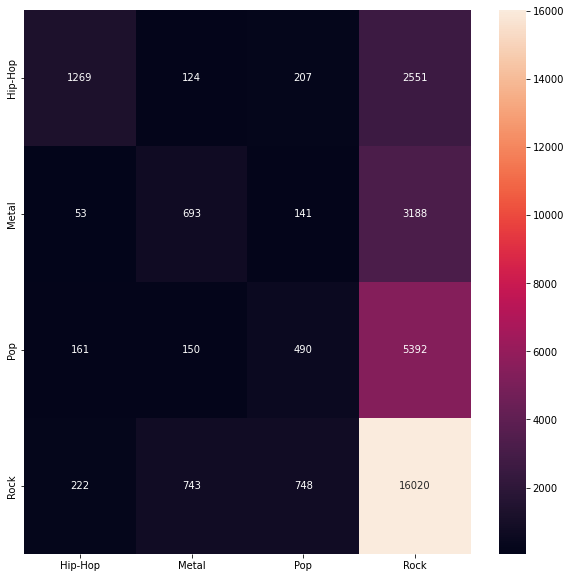

In [23]:
train_by_model(X_train_def_proc, X_test_def_proc, chosenLogisticRegression)

              precision    recall  f1-score   support

           0       0.43      0.26      0.32      4151
           1       0.18      0.20      0.19      4075
           2       0.28      0.04      0.06      6193
           3       0.59      0.82      0.69     17733

    accuracy                           0.52     32152
   macro avg       0.37      0.33      0.32     32152
weighted avg       0.46      0.52      0.46     32152



LogisticRegression(n_jobs=2, random_state=42, solver='saga')

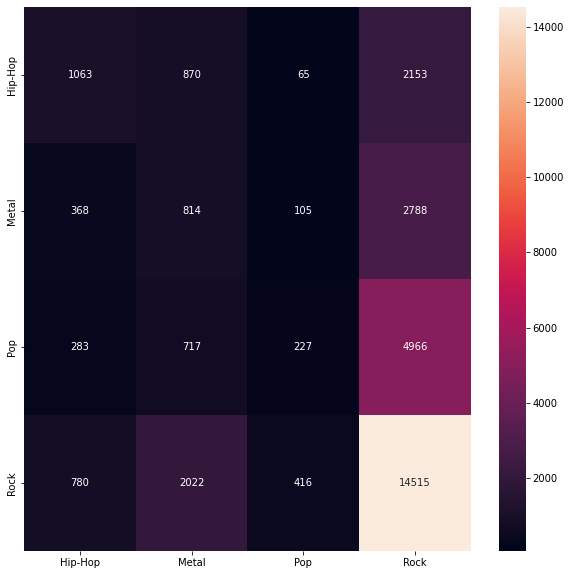

In [24]:
train_by_model(X_train_spec_proc, X_test_spec_proc, chosenLogisticRegression)

              precision    recall  f1-score   support

           0       0.80      0.34      0.48      4151
           1       0.44      0.04      0.08      4075
           2       0.21      0.03      0.06      6193
           3       0.58      0.95      0.72     17733

    accuracy                           0.58     32152
   macro avg       0.51      0.34      0.33     32152
weighted avg       0.52      0.58      0.48     32152



LogisticRegression(n_jobs=2, random_state=42, solver='saga')

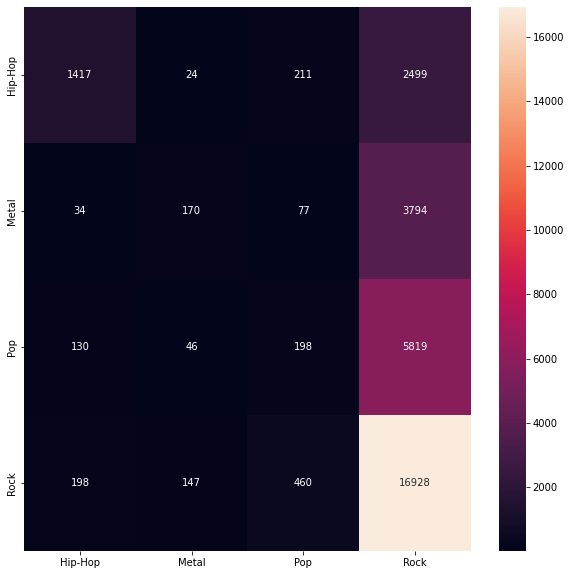

In [37]:
train_by_model(X_train_spec_proc_with_stopwords, X_test_spec_proc_with_stopwords, chosenLogisticRegression)

              precision    recall  f1-score   support

           0       0.67      0.13      0.21      4151
           1       0.30      0.00      0.01      4075
           2       0.56      0.00      0.00      6193
           3       0.56      0.99      0.72     17733

    accuracy                           0.56     32152
   macro avg       0.52      0.28      0.23     32152
weighted avg       0.54      0.56      0.42     32152



LogisticRegression(max_iter=3000, n_jobs=2, random_state=42, solver='saga')

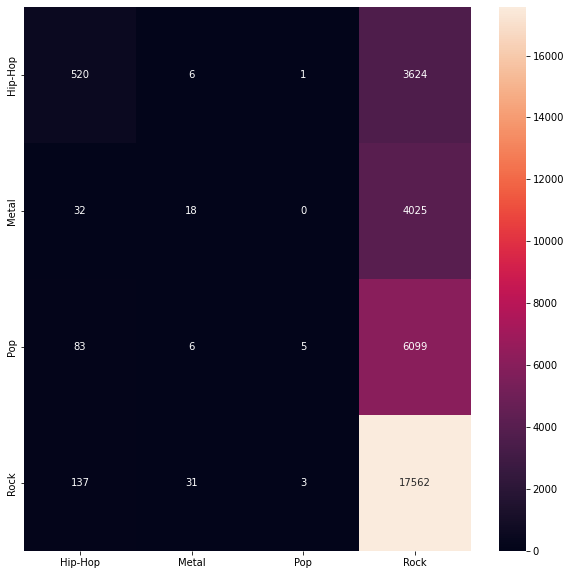

In [40]:
train_by_model(X_train_proc_POS, X_test_proc_POS, LogisticRegression(
    random_state=SEED,
    n_jobs=2,
    max_iter=3000,
    solver="saga",
    multi_class="auto"))

In [76]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      4151
           1       0.27      0.02      0.04      4075
           2       0.25      0.09      0.13      6193
           3       0.61      0.86      0.72     17733

    accuracy                           0.59     32152
   macro avg       0.44      0.42      0.38     32152
weighted avg       0.50      0.59      0.51     32152



AdaBoostClassifier(random_state=42)

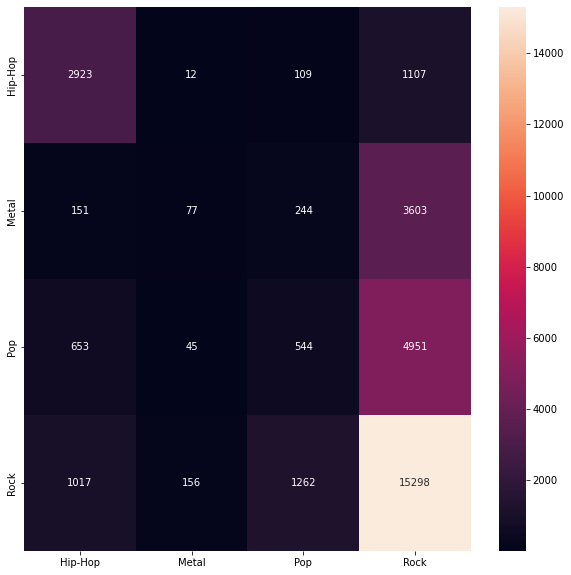

In [68]:
train_by_model(X_train_spec_proc_with_stopwords, X_test_spec_proc_with_stopwords, AdaBoostClassifier(random_state=SEED))

              precision    recall  f1-score   support

           0       0.68      0.54      0.60      4151
           1       0.14      0.01      0.02      4075
           2       0.37      0.05      0.09      6193
           3       0.60      0.94      0.74     17733

    accuracy                           0.60     32152
   macro avg       0.45      0.39      0.36     32152
weighted avg       0.51      0.60      0.50     32152



AdaBoostClassifier()

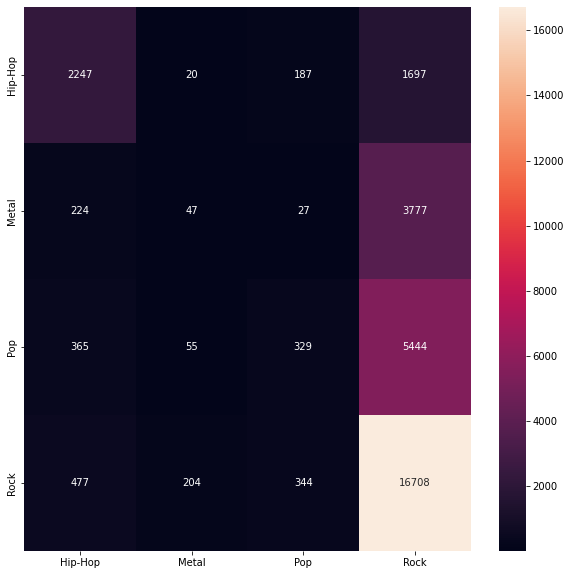

In [41]:
train_by_model(X_train_proc_POS, X_test_proc_POS, AdaBoostClassifier())

# Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.56      0.36      0.44      4151
           1       0.17      0.07      0.10      4075
           2       0.21      0.23      0.22      6193
           3       0.60      0.71      0.65     17733

    accuracy                           0.49     32152
   macro avg       0.38      0.34      0.35     32152
weighted avg       0.46      0.49      0.47     32152



GaussianNB()

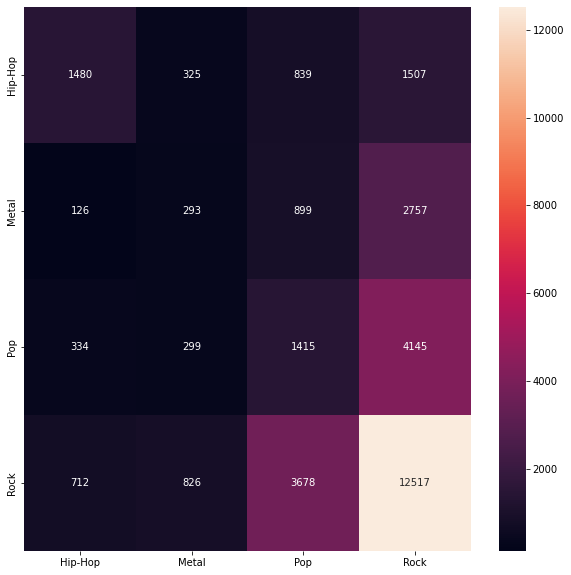

In [42]:
train_by_model(X_train_proc_POS.toarray(), X_test_proc_POS.toarray(), GaussianNB())

              precision    recall  f1-score   support

           0       0.29      0.33      0.31      4151
           1       0.13      0.05      0.07      4075
           2       0.16      0.18      0.17      6193
           3       0.59      0.62      0.60     17733

    accuracy                           0.42     32152
   macro avg       0.29      0.29      0.29     32152
weighted avg       0.41      0.42      0.41     32152



GaussianNB()

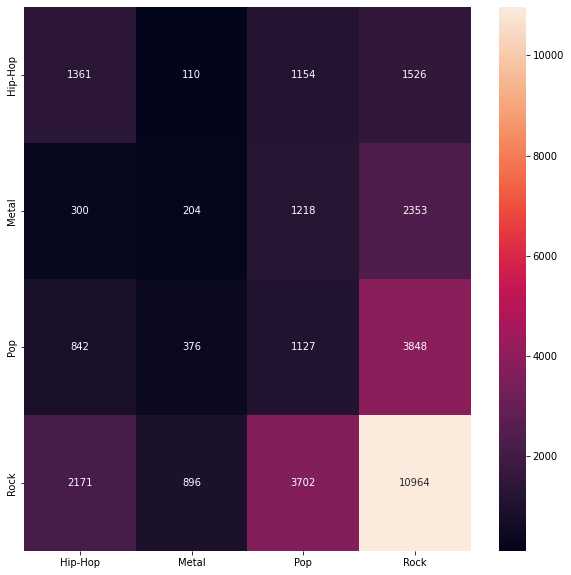

In [28]:
train_by_model(X_train_spec_proc_with_stopwords.toarray(), X_test_spec_proc_with_stopwords.toarray(), GaussianNB())

# Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       0.73      0.37      0.49      4151
           1       0.49      0.14      0.21      4075
           2       0.20      0.02      0.03      6193
           3       0.59      0.95      0.73     17733

    accuracy                           0.59     32152
   macro avg       0.50      0.37      0.36     32152
weighted avg       0.52      0.59      0.50     32152



MultinomialNB(alpha=35)

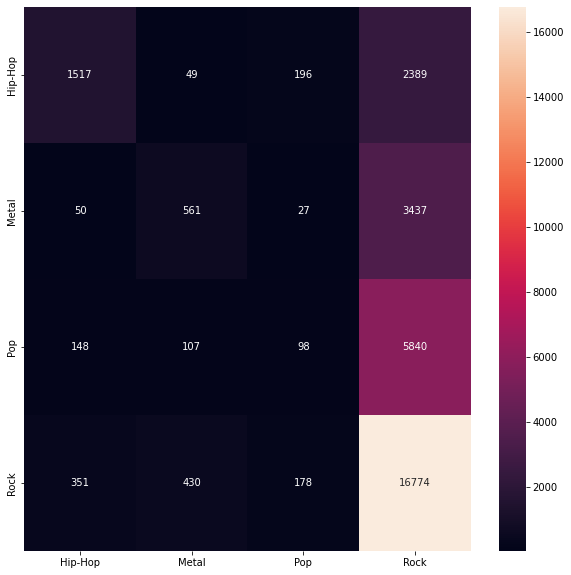

In [47]:
train_by_model(X_train_spec_proc_with_stopwords.toarray(), X_test_spec_proc_with_stopwords.toarray(), MultinomialNB(alpha=35))

C:\Users\Alex D\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex D\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex D\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4151
           1       0.00      0.00      0.00      4075
           2       0.00      0.00      0.00      6193
           3       0.55      1.00      0.71     17733

    accuracy                           0.55     32152
   macro avg       0.14      0.25      0.18     32152
weighted avg       0.30      0.55      0.39     32152



MultinomialNB(alpha=35)

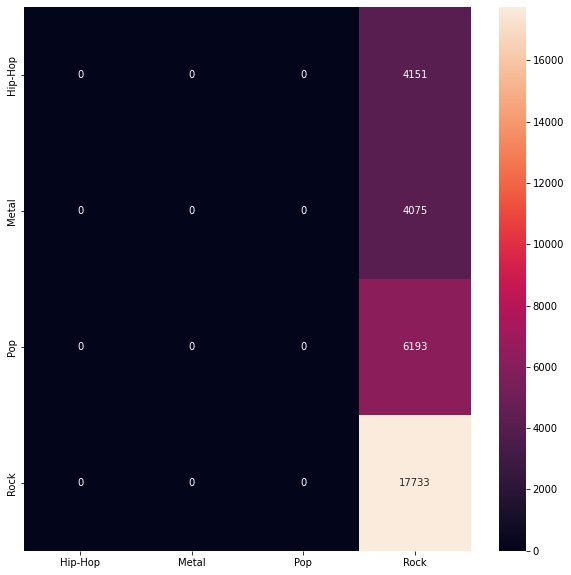

In [52]:
train_by_model(X_train_proc_POS.toarray(), X_test_proc_POS.toarray(), MultinomialNB(alpha=35))

# Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      4151
           1       0.35      0.48      0.41      4075
           2       0.39      0.08      0.14      6193
           3       0.66      0.75      0.70     17733

    accuracy                           0.59     32152
   macro avg       0.51      0.52      0.48     32152
weighted avg       0.56      0.59      0.55     32152



BernoulliNB(alpha=0.001)

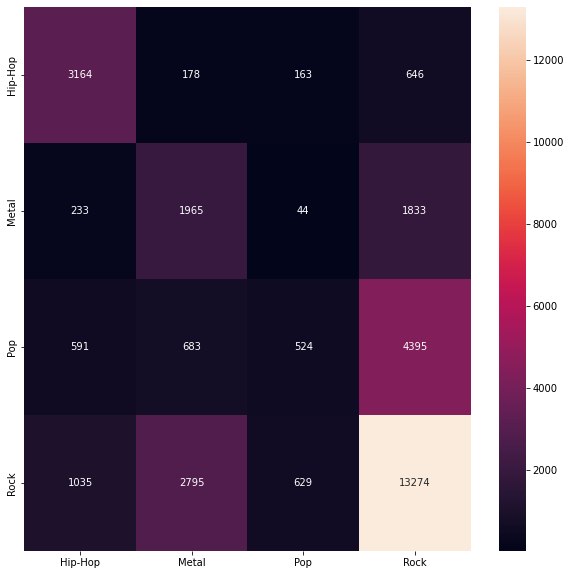

In [57]:
train_by_model(X_train_spec_proc_with_stopwords.toarray(), X_test_spec_proc_with_stopwords.toarray(), BernoulliNB(alpha=0.001))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      4151
           1       0.34      0.50      0.40      4075
           2       0.40      0.20      0.27      6193
           3       0.68      0.70      0.69     17733

    accuracy                           0.59     32152
   macro avg       0.52      0.54      0.52     32152
weighted avg       0.58      0.59      0.58     32152



BernoulliNB(alpha=0.0001)

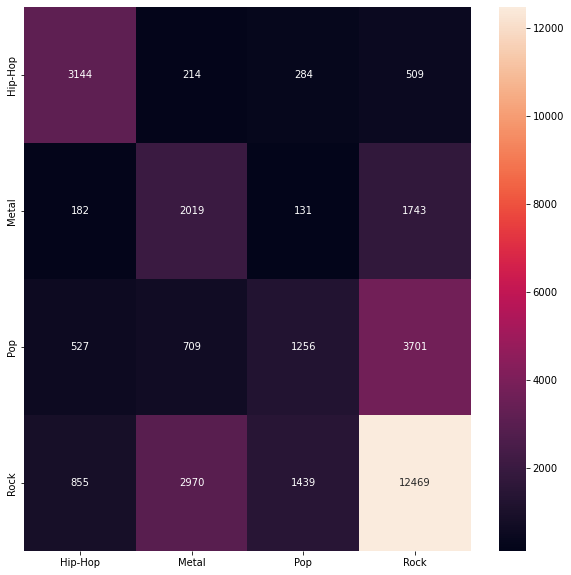

In [64]:
train_by_model(X_train_proc_POS.toarray(), X_test_proc_POS.toarray(), BernoulliNB(alpha=0.0001))